# Churn Predication

### Data set review & preparation

In this section we will seek to explore the structure of our data:

   1) To understand the input space the data set. <br>
   2) And to prepare the sets for exploratory and prediction tasks. 

In [1]:
# importing the required libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from imblearn.over_sampling import SMOTE
%matplotlib inline

# Parameters and Variables

It is convenient to set some (default) parameters and variables for the whole notebook.

In [2]:
font_size = 20
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
scoring_metric = 'recall'
comparison_dict, comparison_test_dict = {}, {}

print('Default Parameters and Variables Set!')

Default Parameters and Variables Set!


### Functions

Since we will reuse parts of the code, it will be helpful to define some functions.

plot_continuous()

In [3]:
def plot_continuous(feature,df):
    '''Plot a histogram and boxplot for the churned and retained distributions for the specified feature.'''
    df_func = df.copy()
    df_func['Exited'] = df_func['Exited'].astype('category')

    fig, (ax1, ax2) = plt.subplots(2,
                                   figsize=(9, 7),
                                   sharex=True,
                                   gridspec_kw={'height_ratios': (.7, .3)})

    for df, color, label in zip([df_retained, df_churned], colors, ['Retained', 'Churned']):
        sns.histplot(data=df,
                     x=feature,
                     bins=15,
                     color=color,
                     alpha=0.66,
                     edgecolor='firebrick',
                     label=label,
                     kde=False,
                     ax=ax1)
    ax1.legend()

    sns.boxplot(x=feature, y='Exited', data=df_func, palette=colors, ax=ax2)
    ax2.set_ylabel('')
    ax2.set_yticklabels(['Retained', 'Churned'])

    plt.tight_layout();


print('Continuous Function Defined!')

Continuous Function Defined!


plot_categorical()

In [4]:
def plot_categorical(feature,df):
    '''For a categorical feature, plot a seaborn.countplot for the total counts of each category next to a barplot for the churn rate.'''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    sns.countplot(x=feature,
                  hue='Exited',
                  data=df,
                  palette=colors,
                  ax=ax1)
    ax1.set_ylabel('Count')
    ax1.legend(labels=['Retained', 'Churned'])

    sns.barplot(x=feature,
                y='Exited',
                data=df,
                palette=colors_cat,
                ax=ax2)
    ax2.set_ylabel('Churn rate')

    if (feature == 'HasCrCard' or feature == 'IsActiveMember'):
        ax1.set_xticklabels(['No', 'Yes'])
        ax2.set_xticklabels(['No', 'Yes'])

    plt.tight_layout();


print('Categorical Function Defined!')


Categorical Function Defined!


plot_conf_mx()

In [5]:
def plot_conf_mx(cm, ax):
    '''Plot a confusion matrix in the specified axes object.'''
    sns.heatmap(data=cm,
                annot=True,
                cmap='Blues',
                annot_kws={'fontsize': 30},
                ax=ax)

    ax.set_xlabel('Predicted Label')
    ax.set_xticks([0.5, 1.5])
    ax.set_xticklabels(['Retained', 'Churned'])

    ax.set_ylabel('True Label')
    ax.set_yticks([0.25, 1.25])
    ax.set_yticklabels(['Retained', 'Churned']);


print('Conf_mx Function Defined!')

Conf_mx Function Defined!


In [6]:
def plot_learning_curve(estimator,
                        X,
                        y,
                        ax,
                        cv=None,
                        train_sizes=np.linspace(0.1, 1.0, 5)):
    '''Plot the learning curves for an estimator in the specified axes object.'''
    train_sizes, train_scores, test_scores = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=-1,
        train_sizes=train_sizes,
        scoring='accuracy')

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.fill_between(train_sizes,
                    train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std,
                    alpha=0.1,
                    color='dodgerblue')
    ax.fill_between(train_sizes,
                    test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std,
                    alpha=0.1,
                    color='darkorange')

    ax.plot(train_sizes,
            train_scores_mean,
            color='dodgerblue',
            marker='o',
            linestyle='-',
            label='Training Score')
    ax.plot(train_sizes,
            test_scores_mean,
            color='darkorange',
            marker='o',
            linestyle='-',
            label='Cross-validation Score')

    ax.set_xlabel('Training Examples')
    ax.set_ylabel('Score')
    ax.legend(loc='best', fontsize=14);


print('Learning_curve Function Defined!')

Learning_curve Function Defined!


clf_performance()

In [7]:
def clf_performance(classifier, classifier_name, classifier_name_abv):
    '''Display the overall performance of a classifier with this template.'''
    
    print('\n', classifier_name)
    print('-------------------------------')
    print('   Best Score ({}): '.format(scoring_metric) + str(np.round(classifier.best_score_, 3)))
    print('   Best Parameters: ')
    for key, value in classifier.best_params_.items():
        print('      {}: {}'.format(key, value))

    y_pred_pp = cross_val_predict(estimator=classifier.best_estimator_,
                                  X=X_train,
                                  y=y_train,
                                  cv=5,
                                  method='predict_proba')[:, 1]
    y_pred = y_pred_pp.round()

    cm = confusion_matrix(y_train, y_pred, normalize='true')

    fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
    comparison_dict[classifier_name_abv] = [
        accuracy_score(y_train, y_pred),
        precision_score(y_train, y_pred),
        recall_score(y_train, y_pred),
        roc_auc_score(y_train, y_pred_pp), fpr, tpr
    ]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    plot_conf_mx(cm, ax1)
    plot_learning_curve(classifier.best_estimator_, X_train, y_train, ax2)

    plt.tight_layout();


print('clf_performance Function Defined!')

clf_performance Function Defined!


plot_feature_imp()

In [8]:
def plot_feature_imp(classifier, classifier_name, color, ax):
    '''Plot the importance of features for a classifier as a barplot.'''
    importances = pd.DataFrame({'Feature': X_train.columns,
                                'Importance': np.round(classifier.best_estimator_.feature_importances_, 3)})

    importances = importances.sort_values('Importance', ascending=True).set_index('Feature')

    importances.plot.barh(color=color,
                          edgecolor='firebrick',
                          legend=False,
                          ax=ax)
    ax.set_title(classifier_name)
    ax.set_xlabel('Importance');


print('plot_feature_imp Function Defined!')

plot_feature_imp Function Defined!


DfPrepPipeline()

In [9]:
# data prep pipeline for test data
def DfPrepPipeline(df_predict,df_train_Cols,minVec,maxVec):
    
    # Add new features
    df_predict['BalanceSalaryRatio'] = df_predict.Balance/df_predict.EstimatedSalary
    df_predict['TenureByAge'] = df_predict.Tenure/(df_predict.Age - 18)
    df_predict['CreditScoreGivenAge'] = df_predict.CreditScore/(df_predict.Age - 18)
    # Reorder the columns
    continuous_vars = ['CreditScore','Age','Tenure','Balance','NumOfProducts','EstimatedSalary','BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
    cat_vars = ['HasCrCard','IsActiveMember',"Geography", "Gender"] 
    df_predict = df_predict[['Exited'] + continuous_vars + cat_vars]
    # Change the 0 in categorical variables to -1
    df_predict.loc[df_predict.HasCrCard == 0, 'HasCrCard'] = -1
    df_predict.loc[df_predict.IsActiveMember == 0, 'IsActiveMember'] = -1
    # One hot encode the categorical variables
    lst = ["Geography", "Gender"]
    remove = list()
    for i in lst:
        for j in df_predict[i].unique():
            df_predict[i+'_'+j] = np.where(df_predict[i] == j,1,-1)
        remove.append(i)
    df_predict = df_predict.drop(remove, axis=1)
    # Ensure that all one hot encoded variables that appear in the train data appear in the subsequent data
    L = list(set(df_train_Cols) - set(df_predict.columns))
    for l in L:
        df_predict[str(l)] = -1        
    # MinMax scaling coontinuous variables based on min and max from the train data
    df_predict[continuous_vars] = (df_predict[continuous_vars]-minVec)/(maxVec-minVec)
    # Ensure that The variables are ordered in the same way as was ordered in the train set
    df_predict = df_predict[df_train_Cols]
    return df_predict

 get_auc_scores()

In [10]:
def get_auc_scores(y_actual, method,method2):
    auc_score = roc_auc_score(y_actual, method); 
    fpr_df, tpr_df, _ = roc_curve(y_actual, method2); 
    return (auc_score, fpr_df, tpr_df)

### A Quick Look at our Data

In [11]:
## Read the data frame
df =pd.read_csv("Bank Customer Historic Data.csv")
df.shape

(10000, 14)

The df has 1000 rows with 14 attributes. We review this further to identify what attributes will be necessary and what data manipulation needs to be carried out before Exploratory analysis and prediction modelling

In [12]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


Our DataFrame has 14 features/attributes and 10K customers/instances. The last feature, 'Exited', is the target variable and indicates whether the customer has churned (0 = No, 1 = Yes). The meaning of the rest of the features can be easily inferred from their name.

Features 'RowNumber', 'CustomerId', and 'Surname' are specific to each customer and can be dropped:

In [13]:
# Drop the columns as explained above
df = df.drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

The info() method can give us valuable information such as the number of non-null values and the type of each feature:

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


 there are no missing values in our DataFrame. The describe() method gives us a statistical summary of the numerical features:

In [15]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


The most important things to note are:
<ol>
<li>The age of customers ranges from 18 to 92, with a mean value approximately equal to 40,</li>
<li>The mean (and median) tenure is 5 years, so the majority of customers is loyal (tenure > 3),</li>
<li> and Approximately 50% of customers are active.</li></ol>
<br>  
EDA will help us understand our dataset better. However, before we look at the data any further, we need to create a test set, put it aside, and use it only to evaluate our Machine Learning models. This practice protects our models from data snooping bias (you can read more on page 51 of [1]) and ensures that evaluation will be performed using unseen data.
</br>

### Exploratory Data Analysis

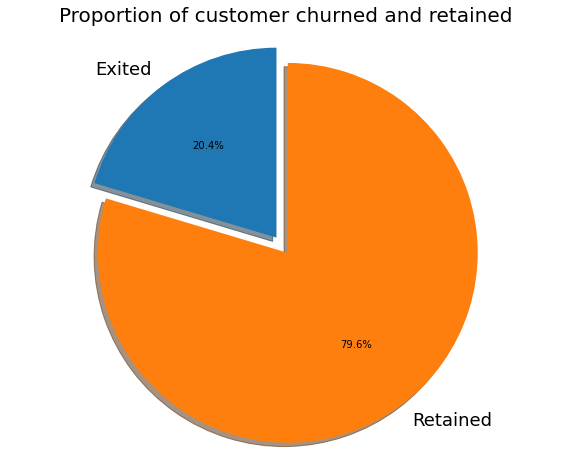

In [16]:
labels = 'Exited', 'Retained'
sizes = [df.Exited[df['Exited']==1].count(), df.Exited[df['Exited']==0].count()]
explode = (0, 0.1)
fig1, ax1 = plt.subplots(figsize=(10, 8))
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')
plt.title("Proportion of customer churned and retained", size = 20)
plt.show()

The bank kept 80% of its clientele.<br>

Notice that our dataset is skewed/imbalanced since the number of instances in the 'Retained' class outnumbers the number of instances in the 'Churned' class by a lot. Therefore, accuracy is probably not the best metric for model performance.<br>

Different visualisation techniques apply to different types of variables, so it's helpful to differentiate between continuous and categorical variables and look at them separately.<br>

In [17]:
continuous = ['Age', 'CreditScore', 'Balance', 'EstimatedSalary']
categorical = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']

print('Continuous: ', ', '.join(continuous))
print('Categorical: ', ', '.join(categorical))

Continuous:  Age, CreditScore, Balance, EstimatedSalary
Categorical:  Geography, Gender, Tenure, NumOfProducts, HasCrCard, IsActiveMember


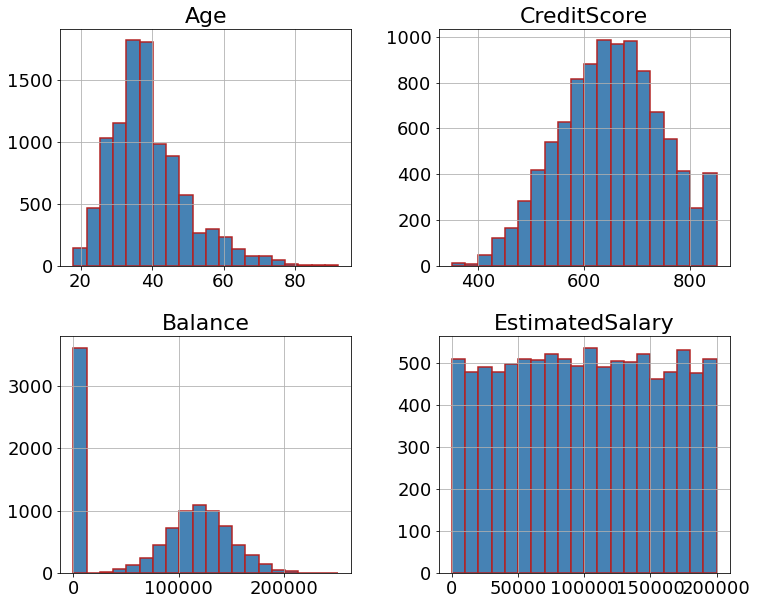

In [18]:
df[continuous].hist(figsize=(12, 10),
                          bins=20,
                          layout=(2, 2),
                          color='steelblue',
                          edgecolor='firebrick',
                          linewidth=1.5)
plt.show()

<ol>
<li>'Age' is slightly tail-heavy, i.e. it extends more further to the right of the median than to the left,</li>
<li>Most values for 'CreditScore' are above 600,</li>
<li>If we ignore the first bin, 'Balance' follows a fairly normal distribution, and</li>
<li>The distribution of 'EstimatedSalary' is more or less uniform and provides little information.</li></ol>

#### Looking for Correlations

We can compute the standard correlation coefficient between every pair of (continuous) features using the pandas' corr() method and plot it as a matrix:

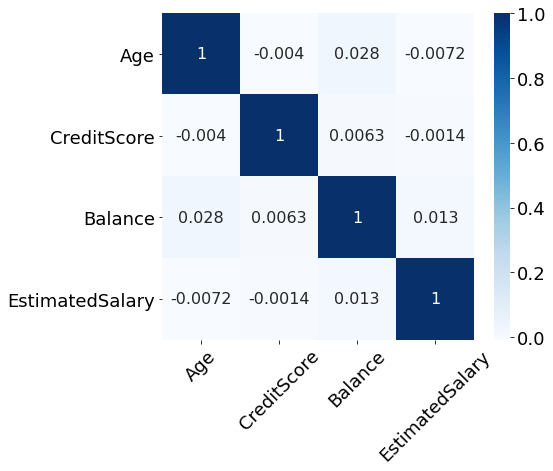

In [19]:
fig, ax = plt.subplots(figsize=(7, 6))

sns.heatmap(df[continuous].corr(),
            annot=True,
            annot_kws={'fontsize': 16},
            cmap='Blues',
            ax=ax)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=360)
plt.show()

There is no significant intercorrelation between our features, so we do not have to worry about multicollinearity.

Let's look at these features in greater detail.

#### Age¶


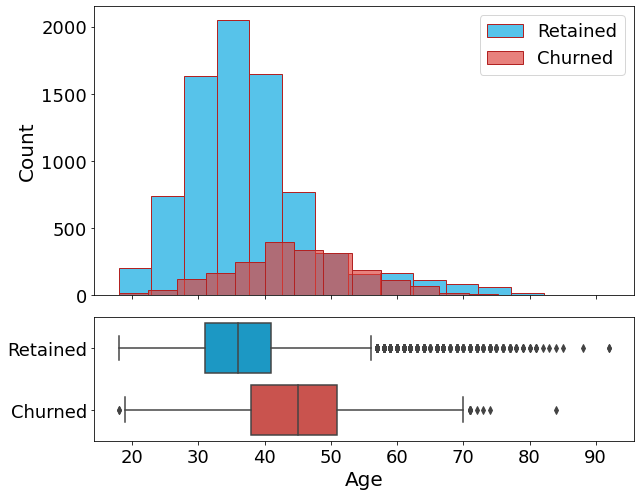

In [20]:
df_churned = df[df['Exited'] == 1]
df_retained = df[df['Exited'] == 0]
plot_continuous('Age',df)

Interestingly, The older customers are churning at more than the younger ones alluding to a difference in service preference in the age categories. The bank may need to review their target market or review the strategy for retention between the different age groups

#### CreditScore

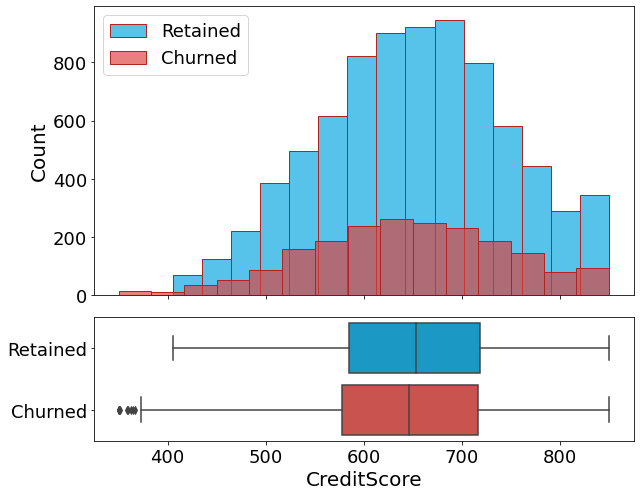

In [21]:
plot_continuous('CreditScore',df)

There is no significant difference between retained and churned customers in terms of their credit scores.

#### Balance

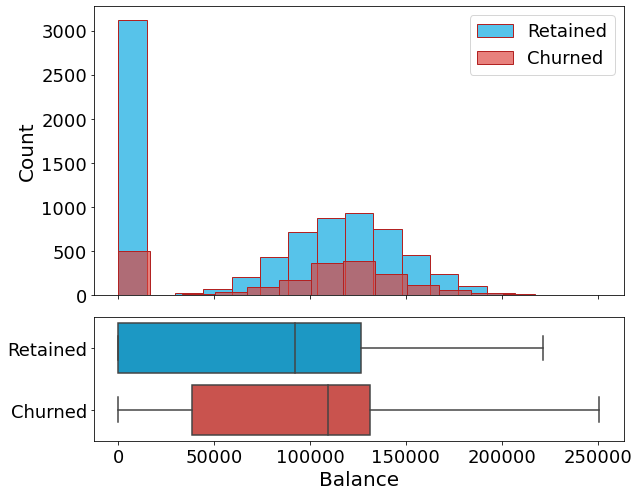

In [22]:
plot_continuous("Balance",df)

Again, the two distributions are quite similar. There is a big percentage of non-churned customers with a low account balance.

#### Estimated Salary

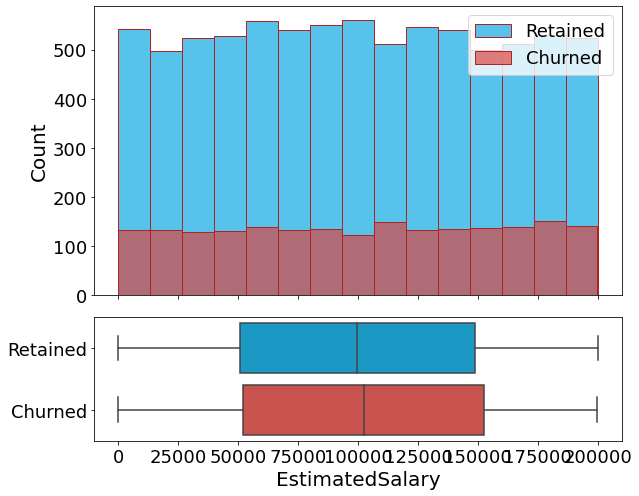

In [23]:
plot_continuous('EstimatedSalary',df)

### Categorical Variables

Let's plot a seaborn.countplot for each categorical feature:

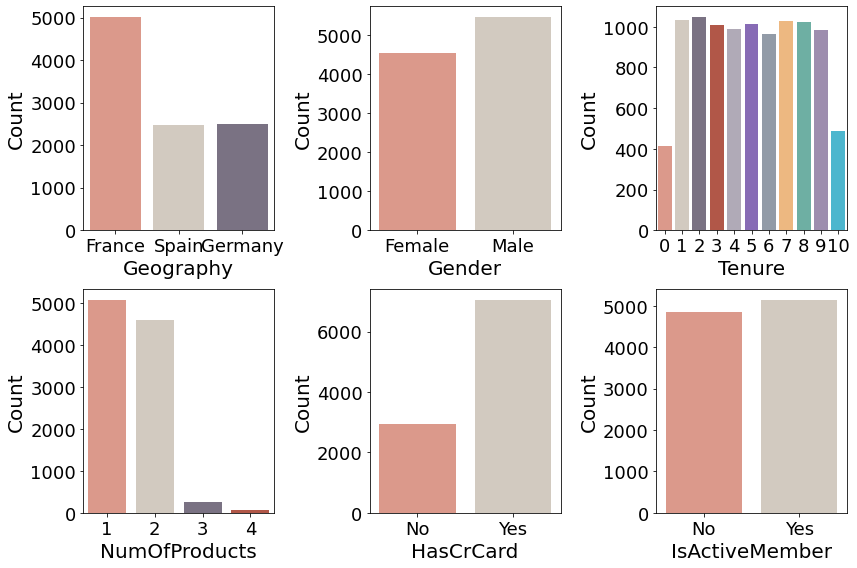

In [24]:
df_cat = df[categorical]

fig, ax = plt.subplots(2, 3, figsize=(12, 8))

for index, column in enumerate(df_cat.columns):

    plt.subplot(2, 3, index + 1)
    sns.countplot(x=column, data=df, palette=colors_cat)

    plt.ylabel('Count')
    if (column == 'HasCrCard' or column == 'IsActiveMember'):
        plt.xticks([0, 1], ['No', 'Yes'])

plt.tight_layout()

Important points:
<ol>
<li>The bank has customers in three countries (France, Spain, and Germany). Most customers are in France.</li>
<li>There are more male customers than females,</li>
<li>Only a small percentage leaves within the first year. The count of customers in tenure years between 1 and 9 is almost the same,</li>
<li>Most of the customers have purchased 1 or 2 products, while a small portion has purchased 3 and 4,</li>
<li>A significant majority of customers has a credit card, and</li>
<li>Almost 50% of customers are not active.</li></ol><br>
Again, we will look at these features in greater detail.

#### Geography

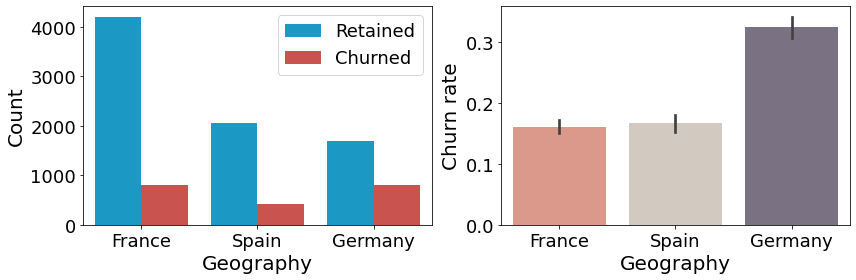

In [25]:
plot_categorical('Geography',df)

Customers in Germany are more likely to churn than customers in the other two countries (the churn rate is almost double compared to Spain and France).

#### Gender

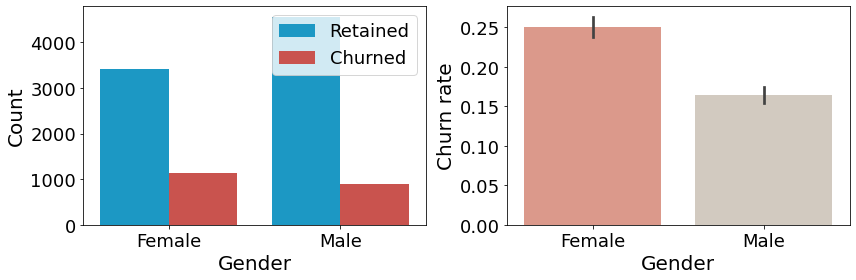

In [26]:
plot_categorical('Gender',df)

Female customers are more likely to churn.

#### Tenure

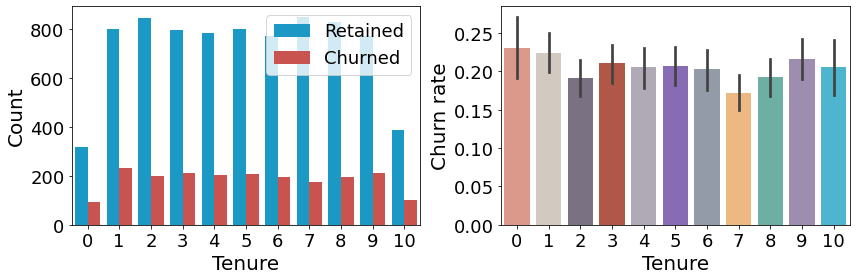

In [27]:
plot_categorical('Tenure',df)

The number of years (tenure) does not seem to affect the churn rate.

#### Number of Products

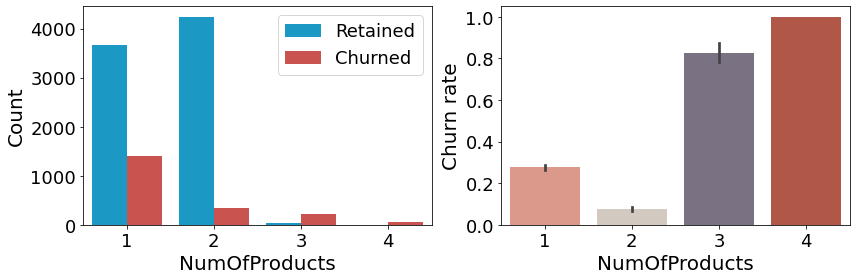

In [28]:
plot_categorical('NumOfProducts',df)

 Interestingly, having 3 or 4 products significantly increases the likelihood of churn. I am not sure how to interpret this result. It could potentially mean that the bank cannot properly support customers with more products which in turn increases customer dissatisfaction

#### Card Holders

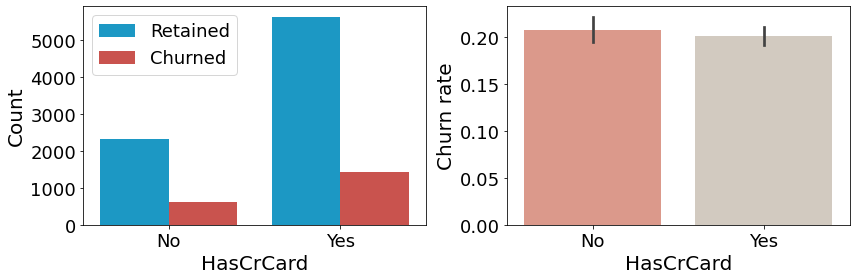

In [29]:
plot_categorical('HasCrCard',df)

Having a credit card does not seem to affect the churn rate.

#### Active Members

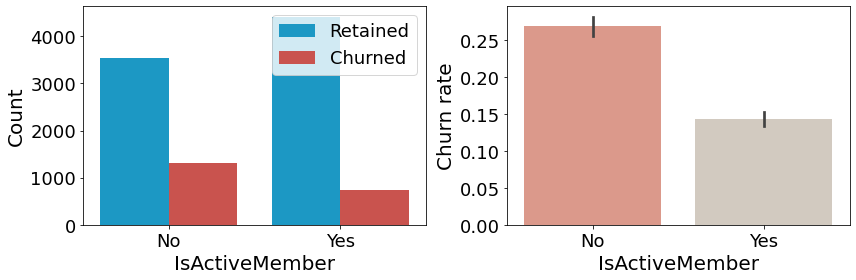

In [30]:
plot_categorical('IsActiveMember',df)

It's not a surprise that inactive customers are more likely to churn. A significant portion of the clientele is inactive; therefore, the bank will benefit from changing its policy so that more customers become active.

### Feature Engineering

In [31]:
# Split Train, test data
df_train = df.sample(frac=0.8,random_state=200)
df_test = df.drop(df_train.index)
print(len(df_train))
print(len(df_test))

8000
2000


We have already performed feature selection by dropping columns 'RowNumber', 'CustomerId', and 'Surname' at the beginning of our notebook. EDA revealed several more features that can be dropped as they do not provide any value in predicting our target variable:
<ol>
<li>'EstimatedSalary' displays a uniform distribution for both types of customers and can be dropped.</li>
<li>The categories in 'Tenure' and 'HasCrCard' have a similar churn rate and are deemed redundant. This can be confirmed from a chi-square test:</li></ol>

In [32]:
df_train['BalanceSalaryRatio'] = df_train.Balance/df_train.EstimatedSalary

In [33]:
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio
8159,461,Spain,Female,25,6,0.00,2,1,1,15306.29,0,0.000000
6332,619,France,Female,35,4,90413.12,1,1,1,20555.21,0,4.398550
8895,699,France,Female,40,8,122038.34,1,1,0,102085.35,0,1.195454
5351,558,Germany,Male,41,2,124227.14,1,1,1,111184.67,0,1.117305
4314,638,France,Male,34,5,133501.36,1,0,1,155643.04,0,0.857741


(-1.0, 5.0)

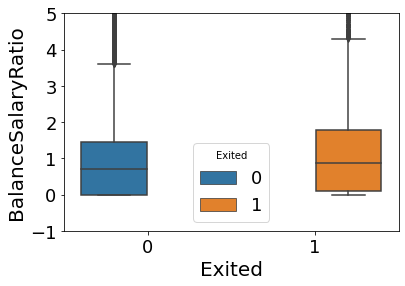

In [34]:
sns.boxplot(y='BalanceSalaryRatio',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 5)

we have seen that the salary has little effect on the chance of a customer churning. However as seen above, the ratio of the bank balance and the estimated salary indicates that customers with a higher balance salary ratio churn more which would be worrying to the bank as this impacts their source of loan capital.

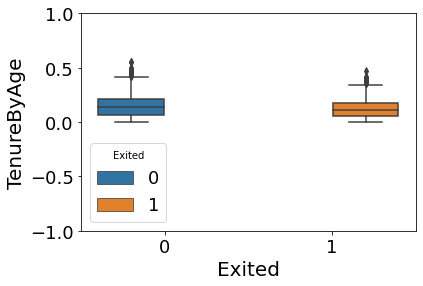

In [35]:
# Given that tenure is a 'function' of age, we introduce a variable aiming to standardize tenure over age:
df_train['TenureByAge'] = df_train.Tenure/(df_train.Age)
sns.boxplot(y='TenureByAge',x = 'Exited', hue = 'Exited',data = df_train)
plt.ylim(-1, 1)
plt.show()

In [36]:
'''Lastly we introduce a variable to capture credit score given age to take into account credit behaviour visavis adult life
:-)'''

df_train['CreditScoreGivenAge'] = df_train.CreditScore/(df_train.Age)



In [37]:
# Resulting Data Frame
df_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
8159,461,Spain,Female,25,6,0.00,2,1,1,15306.29,0,0.000000,0.240000,18.440000
6332,619,France,Female,35,4,90413.12,1,1,1,20555.21,0,4.398550,0.114286,17.685714
8895,699,France,Female,40,8,122038.34,1,1,0,102085.35,0,1.195454,0.200000,17.475000
5351,558,Germany,Male,41,2,124227.14,1,1,1,111184.67,0,1.117305,0.048780,13.609756
4314,638,France,Male,34,5,133501.36,1,0,1,155643.04,0,0.857741,0.147059,18.764706


#### Data prep for model fitting

In [38]:
# Arrange columns by data type for easier manipulation
continuous_vars = ['CreditScore',  'Age', 'Tenure', 'Balance','NumOfProducts', 'EstimatedSalary', 'BalanceSalaryRatio',
                   'TenureByAge','CreditScoreGivenAge']
cat_vars = ['HasCrCard', 'IsActiveMember','Geography', 'Gender']
df_train = df_train[['Exited'] + continuous_vars + cat_vars]
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,0,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,0,1,France,Male


In [40]:
'''For the one hot variables, we change 0 to -1 so that the models can capture a negative relation 
where the attribute in inapplicable instead of 0'''
df_train.loc[df_train.HasCrCard == 0, 'HasCrCard'] = -1
df_train.loc[df_train.IsActiveMember == 0, 'IsActiveMember'] = -1
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography,Gender
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,Spain,Female
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,France,Female
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,France,Female
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,Germany,Male
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,France,Male


In [41]:
# One hot encode the categorical variables
lst = ['Geography', 'Gender']
remove = list()
for i in lst:
    if (df_train[i].dtype == str or df_train[i].dtype == object):
        for j in df_train[i].unique():
            df_train[i+'_'+j] = np.where(df_train[i] == j,1,-1)
        remove.append(i)
df_train = df_train.drop(remove, axis=1)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,461,25,6,0.00,2,15306.29,0.000000,0.240000,18.440000,1,1,1,-1,-1,1,-1
6332,0,619,35,4,90413.12,1,20555.21,4.398550,0.114286,17.685714,1,1,-1,1,-1,1,-1
8895,0,699,40,8,122038.34,1,102085.35,1.195454,0.200000,17.475000,1,-1,-1,1,-1,1,-1
5351,0,558,41,2,124227.14,1,111184.67,1.117305,0.048780,13.609756,1,1,-1,-1,1,-1,1
4314,0,638,34,5,133501.36,1,155643.04,0.857741,0.147059,18.764706,-1,1,-1,1,-1,-1,1


In [42]:
# minMax scaling the continuous variables
minVec = df_train[continuous_vars].min().copy()
maxVec = df_train[continuous_vars].max().copy()
df_train[continuous_vars] = (df_train[continuous_vars]-minVec)/(maxVec-minVec)
df_train.head()

,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge,HasCrCard,IsActiveMember,Geography_Spain,Geography_France,Geography_Germany,Gender_Female,Gender_Male
8159,0,0.222,0.094595,0.6,0.000000,0.333333,0.076118,0.000000,0.432000,0.323157,1,1,1,-1,-1,1,-1
6332,0,0.538,0.229730,0.4,0.360358,0.000000,0.102376,0.003317,0.205714,0.305211,1,1,-1,1,-1,1,-1
8895,0,0.698,0.297297,0.8,0.486406,0.000000,0.510225,0.000901,0.360000,0.300198,1,-1,-1,1,-1,1,-1
5351,0,0.416,0.310811,0.2,0.495130,0.000000,0.555744,0.000843,0.087805,0.208238,1,1,-1,-1,1,-1,1
4314,0,0.576,0.216216,0.5,0.532094,0.000000,0.778145,0.000647,0.264706,0.330882,-1,1,-1,1,-1,-1,1


Finally, we will split the train set into 'X_train' and 'y_train' sets:

In [43]:
y_train = df_train['Exited']
X_train = df_train.drop('Exited', 1)

print("sets are created")

sets are created


#### Addressing Class Imbalance

As we have seen previously, there is an imbalance in the classes to be predicted, with one class (0 – retained) much more prevalent than the other (1 - churned):

In [44]:
y_train.value_counts()

0    6353
1    1647
Name: Exited, dtype: int64

Class imbalance is usually a problem and occurs in many real-world tasks. Classification using imbalanced data is biased in favour of the majority class, meaning that machine learning algorithms will likely result in models that do little more than predict the most common class.<br><br>
To overcome with this probelm , i decide to use oversampling technique i.e SMOTE


In [45]:
over = SMOTE(sampling_strategy='auto', random_state=random_state)
X_train, y_train = over.fit_resample(X_train, y_train)

y_train.value_counts()

0    6353
1    6353
Name: Exited, dtype: int64

### Machine Learning Model building

We start this section by first creating two simple models to estimate the baseline performance on the training set. Specifically, we will use Gaussian Naïve Bayes and Logistic Regression. We will use their default parameters and evaluate their (mean) recall by performing k-fold cross-validation. The idea behind k-fold cross-validation, which is  it splits the (training) set into k subsets/folds, trains the models using k-1 folds, and evaluates the model on the remaining one fold. This process is repeated until every fold is tested once.

In [46]:
# Support functions
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_predict,learning_curve,cross_val_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform

# Fit models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier

# Scoring functions
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix,roc_auc_score
from sklearn.metrics  import precision_score,recall_score


In [47]:
clf_list = [('Gaussian Naive Bayes', GaussianNB()),
            ('Logistic Regression', LogisticRegression(random_state=random_state))]

cv_base_mean, cv_std = [], []
for clf in clf_list:

    cv = cross_val_score(estimator=clf[1],
                         X=X_train,
                         y=y_train,
                         scoring=scoring_metric,
                         cv=5,
                         n_jobs=-1)

    cv_base_mean.append(cv.mean())
    cv_std.append(cv.std())

print('Baseline Models (Recall):')

for i in range(len(clf_list)):
    print('   {}: {}'.format(clf_list[i][0], np.round(cv_base_mean[i], 2)))

Baseline Models (Recall):
   Gaussian Naive Bayes: 0.69
   Logistic Regression: 0.73


Note: We could have used more (powerful) classifiers such as Random Forests or/and XGBoost. However, I preferred to exclude them at this stage as their default parameters make them more susceptible to overfitting the training set and hence provide inaccurate baseline performance.


We are now ready to start building machine learning models. The six classifiers I have selected are the following
<ol>
    <li> Logistic Regression</li>
    <li> Support Vector Classifier,</li>
    <li>Random Forest Classifier,</li>
    <li>Gradient Boosting Classifier,</li>
    <li>Xtreme Gradient Boosting Classifier, and</li>
    <li>Light Gradient Boosting Machine</li></ol>

#### Logistic Regression

/Users/ritkumar/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ritkumar/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ritkumar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/ritkumar/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logist


 Logistic Regression
-------------------------------
   Best Score (recall): 0.732
   Best Parameters: 
      C: 10
      max_iter: 100
      penalty: l1
      solver: liblinear


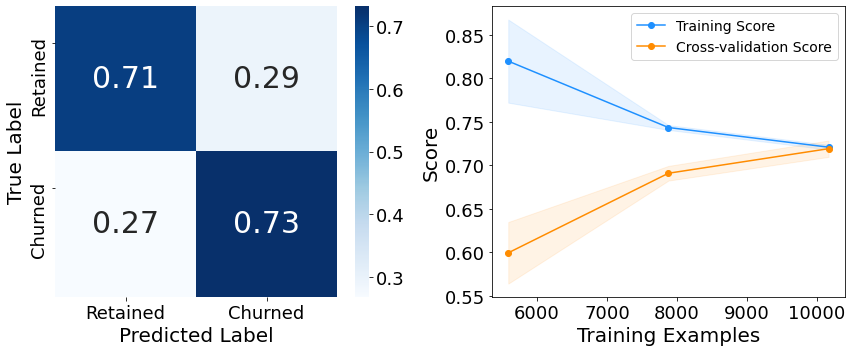

In [48]:
lr = LogisticRegression(random_state=random_state)

param_grid = {
    'max_iter': [100],
    'penalty': ['l1', 'l2'],
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

lr_clf = GridSearchCV(estimator=lr,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_lr_clf = lr_clf.fit(X_train, y_train)
clf_performance(best_lr_clf, 'Logistic Regression', 'LR')

#### Support Vector Classifier


 Support Vector Classifier
-------------------------------
   Best Score (recall): 0.742
   Best Parameters: 
      C: 1
      kernel: linear


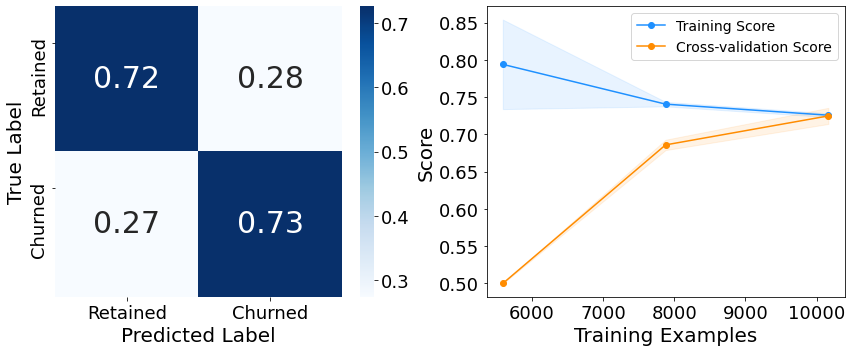

In [49]:
svc = SVC(probability=True, random_state=random_state)

param_grid = tuned_parameters = [{'kernel': ['rbf'],
                                  'gamma': ['scale', 'auto'],
                                  'C': [.1, 1, 2]},
                                 {'kernel': ['linear'],
                                  'C': [.1, 1, 10]}
                                ]

svc_clf = GridSearchCV(estimator=svc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_svc_clf = svc_clf.fit(X_train, y_train)
clf_performance(best_svc_clf, 'Support Vector Classifier', 'SVC')

#### Random Forest


 Random Forest
-------------------------------
   Best Score (recall): 0.811
   Best Parameters: 
      bootstrap: True
      criterion: entropy
      max_depth: 6
      max_features: auto
      min_samples_leaf: 5
      min_samples_split: 2
      n_estimators: 100


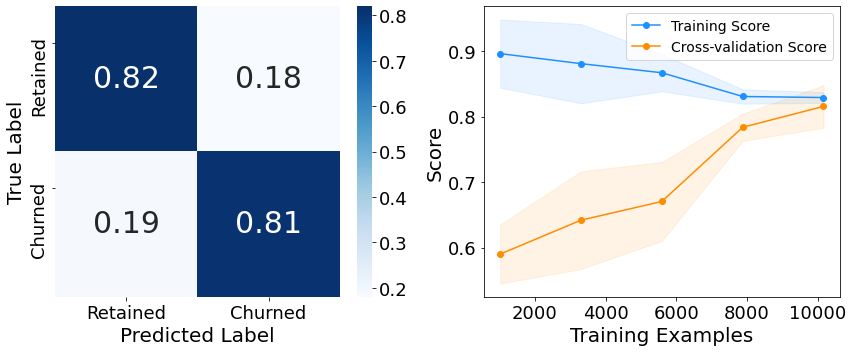

In [50]:
rf = RandomForestClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [100],
    'criterion': ['entropy', 'gini'],
    'bootstrap': [True, False],
    'max_depth': [6],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [2, 3, 5],
    'min_samples_split': [2, 3, 5]
}

rf_clf = GridSearchCV(estimator=rf,
                      param_grid=param_grid,
                      scoring=scoring_metric,
                      cv=5,
                      verbose=False,
                      n_jobs=-1)

best_rf_clf = rf_clf.fit(X_train, y_train)
clf_performance(best_rf_clf, 'Random Forest', 'RF')

#### Gradient Boosting Classifier¶


 Gradient Boosting Classifier
-------------------------------
   Best Score (recall): 0.812
   Best Parameters: 
      learning_rate: 0.01
      max_depth: 3
      max_features: auto
      min_samples_leaf: 5
      min_samples_split: 5
      n_estimators: 600
      n_iter_no_change: 20
      subsample: 0.66
      tol: 0.01
      validation_fraction: 0.2


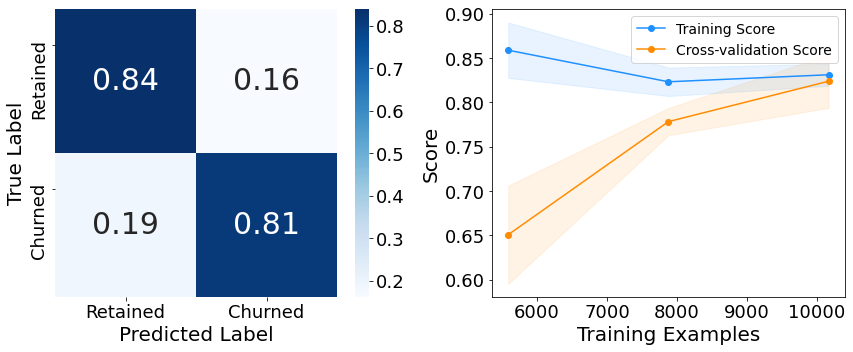

In [51]:
gbc = GradientBoostingClassifier(random_state=random_state)
param_grid = {
    'n_estimators': [600],
    'subsample': [0.66, 0.75],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3],  # default=3
    'min_samples_split': [5, 7],
    'min_samples_leaf': [3, 5],
    'max_features': ['auto', 'log2', None],
    'n_iter_no_change': [20],
    'validation_fraction': [0.2],
    'tol': [0.01]
}

gbc_clf = GridSearchCV(estimator=gbc,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_gbc_clf = gbc_clf.fit(X_train, y_train)
clf_performance(best_gbc_clf, 'Gradient Boosting Classifier', 'GBC')

In [52]:
best_gbc_clf.best_estimator_.n_estimators_

301

#### XGBoost Classifier


 XGBoost Classifier
-------------------------------
   Best Score (recall): 0.812
   Best Parameters: 
      colsample_bytree: 0.5
      gamma: 0.1
      learning_rate: 0.001
      max_depth: 4
      min_child_weight: 1
      n_estimators: 50
      reg_alpha: 2
      reg_lambda: 1
      subsample: 0.75


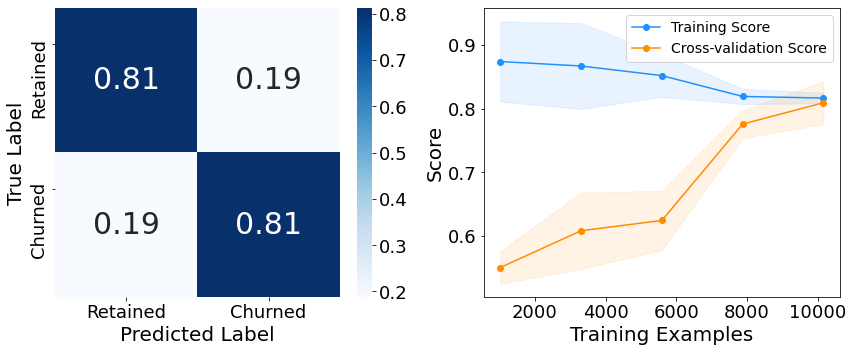

In [53]:
xgb = XGBClassifier(random_state=random_state)

param_grid = {
    'n_estimators': [50],
    'learning_rate': [0.001, 0.01],
    'max_depth': [3, 4],  # default=6
    'reg_alpha': [1, 2],
    'reg_lambda': [1, 2],
    'subsample': [0.5, 0.75],
    'colsample_bytree': [0.50, 0.75],
    'gamma': [0.1, 0.5, 1],
    'min_child_weight': [1]
}

xgb_clf = GridSearchCV(estimator=xgb,
                       param_grid=param_grid,
                       scoring=scoring_metric,
                       cv=5,
                       verbose=False,
                       n_jobs=-1)

best_xgb_clf = xgb_clf.fit(X_train, y_train)
clf_performance(best_xgb_clf, 'XGBoost Classifier', 'XGB')

#### LGBMClassifier


 LGBMClassifier
-------------------------------
   Best Score (recall): 0.811
   Best Parameters: 
      feature_fraction: 0.5
      learning_rate: 0.01
      max_depth: 5
      min_child_samples: 5
      n_estimators: 200
      num_leaves: 10
      reg_alpha: 0.5
      reg_lambda: 0.5


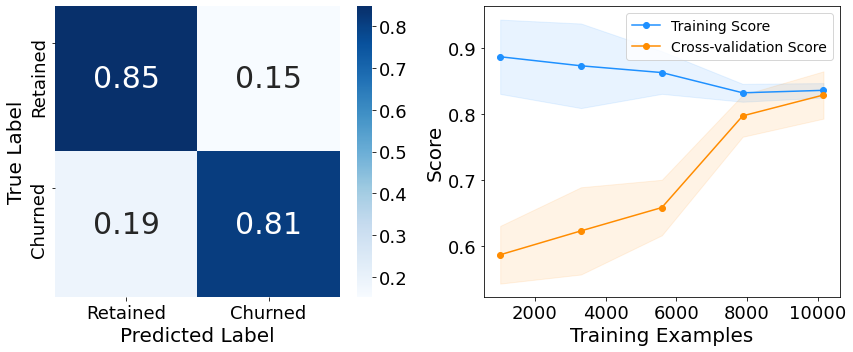

In [54]:
lgbmc = LGBMClassifier(random_state=random_state)

param_grid = {
    'max_depth': [5],
    'num_leaves': [5, 10],
    'learning_rate': [0.001, 0.01],
    'n_estimators': [200],
    'feature_fraction': [0.5],
    'min_child_samples': [5, 10],
    'reg_alpha': [0.1, 0.5],
    'reg_lambda': [0.1, 0.5]
}

lgbmc_clf = GridSearchCV(estimator=lgbmc,
                         param_grid=param_grid,
                         scoring=scoring_metric,
                         cv=5,
                         verbose=False,
                         n_jobs=-1)

best_lgbmc_clf = lgbmc_clf.fit(X_train, y_train)
clf_performance(best_lgbmc_clf, 'LGBMClassifier', 'LGBMC')


#### Ensemble Learning

We can combine the predictions of all these classifiers to determine if we get better predictive performance compared to each individual constituent classifier. This practice is the main motivation behind Ensemble Learning.<br>

Specifically, I will use Soft Voting. In this case, every individual classifier provides a probability value that a specific data point belongs to a particular target class. The predictions are weighted by the classifier's importance and summed up. Then the target label with the greatest sum of weighted probabilities wins the vote.

Soft Voting
-----------------
  Recall:  0.817


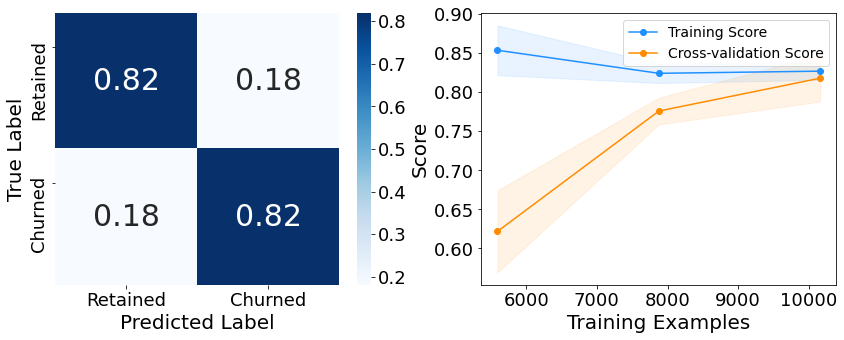

In [55]:
estimators = [('LR', best_lr_clf.best_estimator_),
              ('SCV', best_svc_clf.best_estimator_),
              ('RF', best_rf_clf.best_estimator_),
              ('GBC', best_gbc_clf.best_estimator_),
              ('XGB', best_xgb_clf.best_estimator_),
              ('LGBMC', best_lgbmc_clf.best_estimator_)]

tuned_voting_soft = VotingClassifier(estimators=estimators[1:],
                                     voting='soft',
                                     n_jobs=-1)
estimators.append(('SoftV', tuned_voting_soft))

y_pred_pp = cross_val_predict(tuned_voting_soft,
                              X_train,
                              y_train,
                              cv=5,
                              method='predict_proba')[:, 1]
y_pred = y_pred_pp.round()

cm = confusion_matrix(y_train, y_pred, normalize='true')
fpr, tpr, _ = roc_curve(y_train, y_pred_pp)
comparison_dict['SVot'] = [
    accuracy_score(y_train, y_pred),
    precision_score(y_train, y_pred),
    recall_score(y_train, y_pred),
    roc_auc_score(y_train, y_pred_pp), fpr, tpr
]

print('Soft Voting\n-----------------')
print('  Recall: ', np.round(recall_score(y_train, y_pred), 3))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

plot_conf_mx(cm, ax1)
plot_learning_curve(tuned_voting_soft, X_train, y_train, ax2)

## Results

#### Learning Curves

For all models, there is a tiny gap between the two curves at the end of training. This observation indicates that we do not overfit the training set.



### Feature Importance¶
Some classifiers allow us to visualise feature importance:

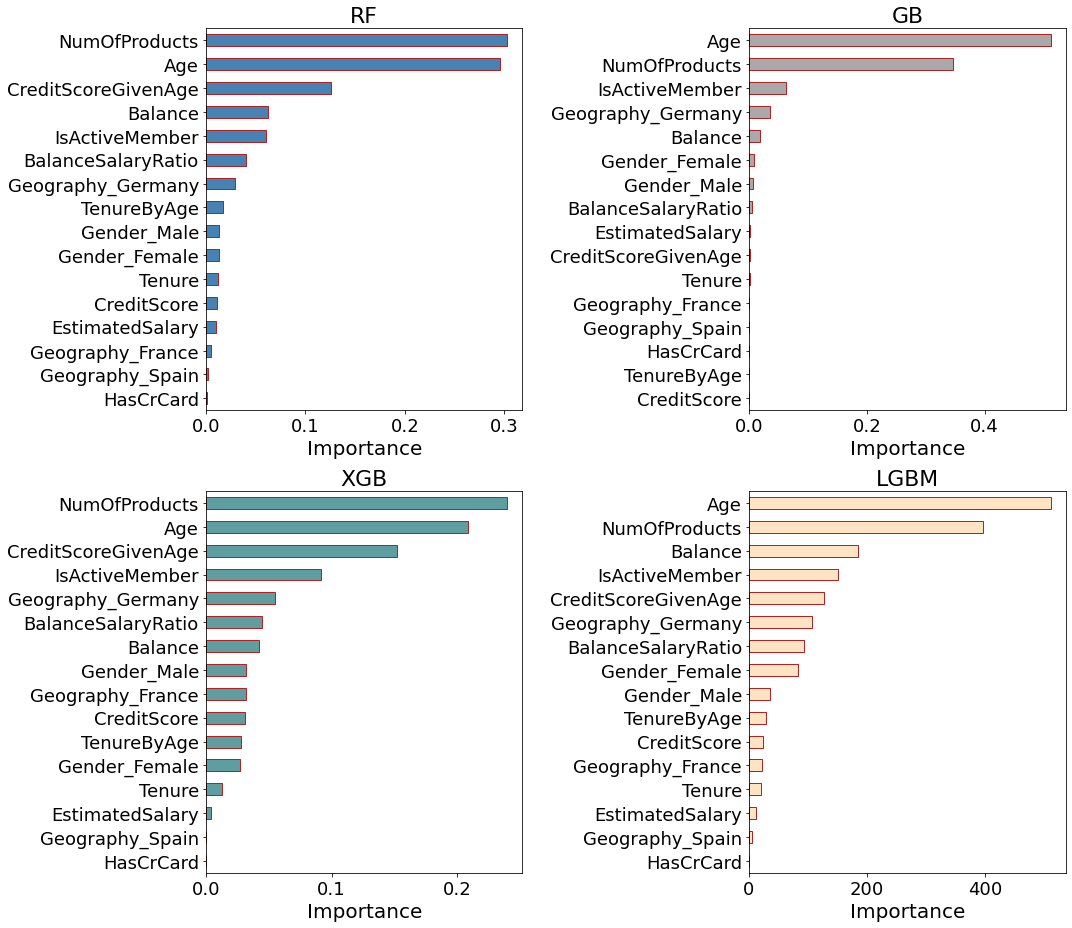

In [56]:
colors_fi = ['steelblue', 'darkgray', 'cadetblue', 'bisque']

fig = plt.subplots(2, 2, figsize=(15, 13))

for i, (name, clf) in enumerate(zip(['RF', 'GB', 'XGB', 'LGBM'],
                                    [best_rf_clf, best_gbc_clf, best_xgb_clf, best_lgbmc_clf])):

    ax = plt.subplot(2, 2, i + 1)
    plot_feature_imp(clf, name, colors_fi[i], ax)
    plt.ylabel('')

plt.tight_layout();

'Age' and 'NumOfProducts' seem like the most useful features for all classifiers, followed by 'IsActiveMember',Geography', 'Balance',. On the other hand, 'CreditScore' is the least important feature with a small value close to zero for all estimators apart from LGBM.

#### Performance Comparison

Initially, we can compare the performance of our classifiers in terms of four individual metrics (Accuracy, precision, recall, and area under the ROC curve or simply AUC):

In [57]:
comparison_matrix = {}
for key, value in comparison_dict.items():
    comparison_matrix[str(key)] = value[0:4]

comparison_df = pd.DataFrame(comparison_matrix,
                             index=['Accuracy', 'Precision', 'Recall', 'AUC']).T
comparison_df.style.highlight_max(color='indianred', axis=0)

,Accuracy,Precision,Recall,AUC
LR,0.719109,0.713628,0.731938,0.789783
SVC,0.725012,0.724870,0.725327,0.789783
RF,0.815678,0.818384,0.811428,0.900721
GBC,0.824886,0.833657,0.811742,0.902231
XGB,0.811034,0.810692,0.811585,0.890108
LGBMC,0.829372,0.841856,0.811113,0.909987
SVot,0.818117,0.818669,0.817252,0.896243


Text(-0.5, 0.73, '0.70')

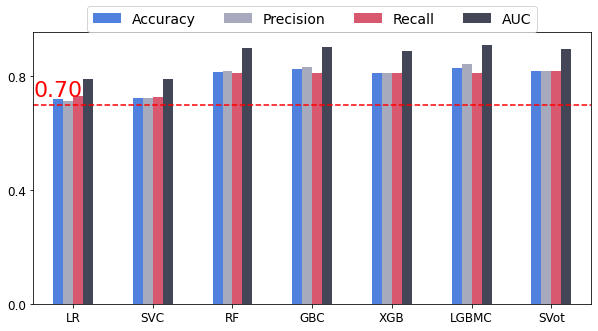

In [58]:
comparison_df.plot(kind='bar',
                   figsize=(10, 5),
                   fontsize=12,
                   color=['#5081DE', '#A7AABD', '#D85870', '#424656'])

plt.legend(loc='upper center',
           fontsize=font_size - 6,
           ncol=len(comparison_df.columns),
           bbox_to_anchor=(0.5, 1.12))
plt.xticks(rotation=0)
plt.yticks([0, 0.4, 0.8])

plt.axhline(y=0.70, color='red', linestyle='--')
plt.text(x=-0.5, y=0.73, s='0.70', size=font_size + 2, color='red')

We seek to add features that are likely to have an impact on the probability of churning. We first split the train and test sets

All other classifiers have a recall higher than 70% (baseline performance). However, the LGBM classifier has the best overall performance with the highest accuracy, precision, and AUC.<br>

Using single metrics is not the only way of comparing the predictive performance of classification models. The ROC curve (Receiver Operating Characteristic curve) is a graph showing the performance of a classifier at different classification thresholds. It plots the true positive rate (another name for recall) against the false positive rate.

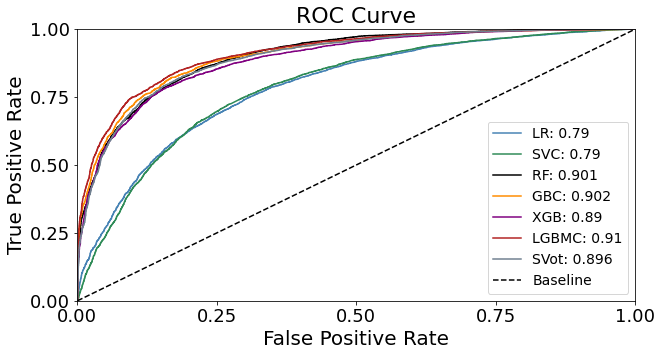

In [59]:
fig, ax = plt.subplots(figsize=(10, 5))

for index, key in enumerate(comparison_dict.keys()):
    auc, fpr, tpr = comparison_dict[key][3], comparison_dict[key][4], comparison_dict[key][5]
    ax.plot(fpr,
            tpr,
            color=colors_comp[index],
            label='{}: {}'.format(key, np.round(auc, 3)))

ax.plot([0, 1], [0, 1], 'k--', label='Baseline')

ax.set_title('ROC Curve')
ax.set_xlabel('False Positive Rate')
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_ylabel('True Positive Rate')
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.autoscale(axis='both', tight=True)
ax.legend(fontsize=14);

The dashed diagonal line represents a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

In our case, all classifiers, apart from Logistic Regression, perform similarly. It seems that LGBMC performs marginally better, as evidenced by the slightly higher AUC (0.91).

### Evaluating the Test Set¶

In [60]:
# Make the data transformation for test data
df_test = DfPrepPipeline(df_test,df_train.columns,minVec,maxVec)
df_test = df_test.mask(np.isinf(df_test))
df_test = df_test.dropna()

y_test = df_test['Exited']
X_test = df_test.drop('Exited', 1)
print('Preprocessing Complete!')

Preprocessing Complete!


In [61]:
print(classification_report(y_test, best_lgbmc_clf.best_estimator_.predict(X_test)))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90      1607
           1       0.58      0.63      0.61       389

    accuracy                           0.84      1996
   macro avg       0.75      0.76      0.75      1996
weighted avg       0.85      0.84      0.84      1996



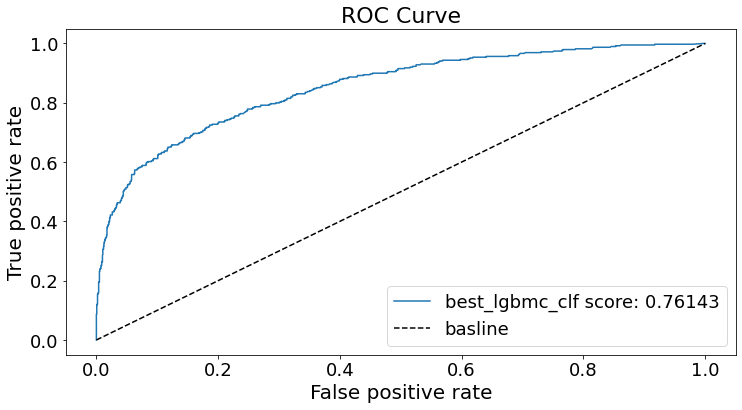

In [62]:
auc_lgbmc_test, fpr_lgbmc_test, tpr_lgbmc_test = get_auc_scores(y_test, best_lgbmc_clf.best_estimator_.predict(X_test),
                                                       best_lgbmc_clf.best_estimator_.predict_proba(X_test)[:,1])
plt.figure(figsize = (12,6), linewidth= 1)
plt.plot(fpr_lgbmc_test, tpr_lgbmc_test, label = 'best_lgbmc_clf score: ' + str(round(auc_lgbmc_test, 5)))
plt.plot([0,1], [0,1], 'k--', label ='basline')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve')
plt.legend(loc='best')
#plt.savefig('roc_results_ratios.png')
plt.show()

### Conclusions
#### Our notebook just came to an end! Our final report to the bank should be based on two main points:
<ol>
    <li>EDA can help us identify which features contribute to customer churn. Additionally, feature importance
        analysis can quantify the importance of each feature in predicting the likelihood of churn. Our results reveal
        that the most significant feature is age (older customers are more likely to churn), followed by the number of
        products (having more products increases a customer’s likelihood to churn). The bank could use our findings to
        adapt and improve its services in a way that increases satisfaction for those customers more likely to churn.</li>
    <li>We can build several machine learning models with recall approximately equal to 63%, meaning that they can
        successfully detect almost 65% of those customers more luckily to churn. Perhaps, adding more features or/and
        records could help us improve predictive performance. Therefore, the bank could benefit from investing in
        gathering more data.</li>
    <li>In ROC Curve , all classifiers, apart from Logistic Regression, perform similarly. It seems that LGBM performs marginally better, as evidenced by the slightly higher AUC (0.91) on Train Data.</li>
    <li> In Test Data also LGBM perform better with AUC (.78)</li>
 </ol>

